In [1]:
from qiskit import QuantumCircuit as QC, assemble,Aer, transpile
from math import gcd
from qiskit.visualization import plot_bloch_multivector,plot_histogram
sim= Aer.get_backend('aer_simulator')
import matplotlib.pyplot as plt
import numpy as np
from numpy.random import randint
import pandas as pd
from fractions import Fraction


In [3]:
def c_amod15(a, power):
    """Controlled multiplication by a mod 15"""
    if a not in [2,7,8,11,13]:
        raise ValueError("'a' must be 2,7,8,11 or 13")
    U = QC(4)        
    for iteration in range(power):
        if a in [2,13]:
            U.swap(0,1)
            U.swap(1,2)
            U.swap(2,3)
        if a in [7,8]:
            U.swap(2,3)
            U.swap(1,2)
            U.swap(0,1)
        if a == 11:
            U.swap(1,3)
            U.swap(0,2)
        if a in [7,11,13]:
            for q in range(4):
                U.x(q)
    U = U.to_gate()
    U.name = "%i^%i mod 15" % (a, power)
    c_U = U.control()
    return c_U

In [4]:
n_count= 8 #number of counting qubit
a=7

Circuit for QFT

In [8]:
def qft_dagger(n):
    """n-qubit QFT dagger the first n qubits in circ"""
    qc = QC(n)
    for qubit in range(n//2):
        qc.swap(qubit, n-qubit-1)
    for j in range(n):
        for m in range(j):
            qc.cp(-np.pi/float(2**(j-m)), m, j)
        qc.h(j)
    qc.name = "QFT†"
    return qc

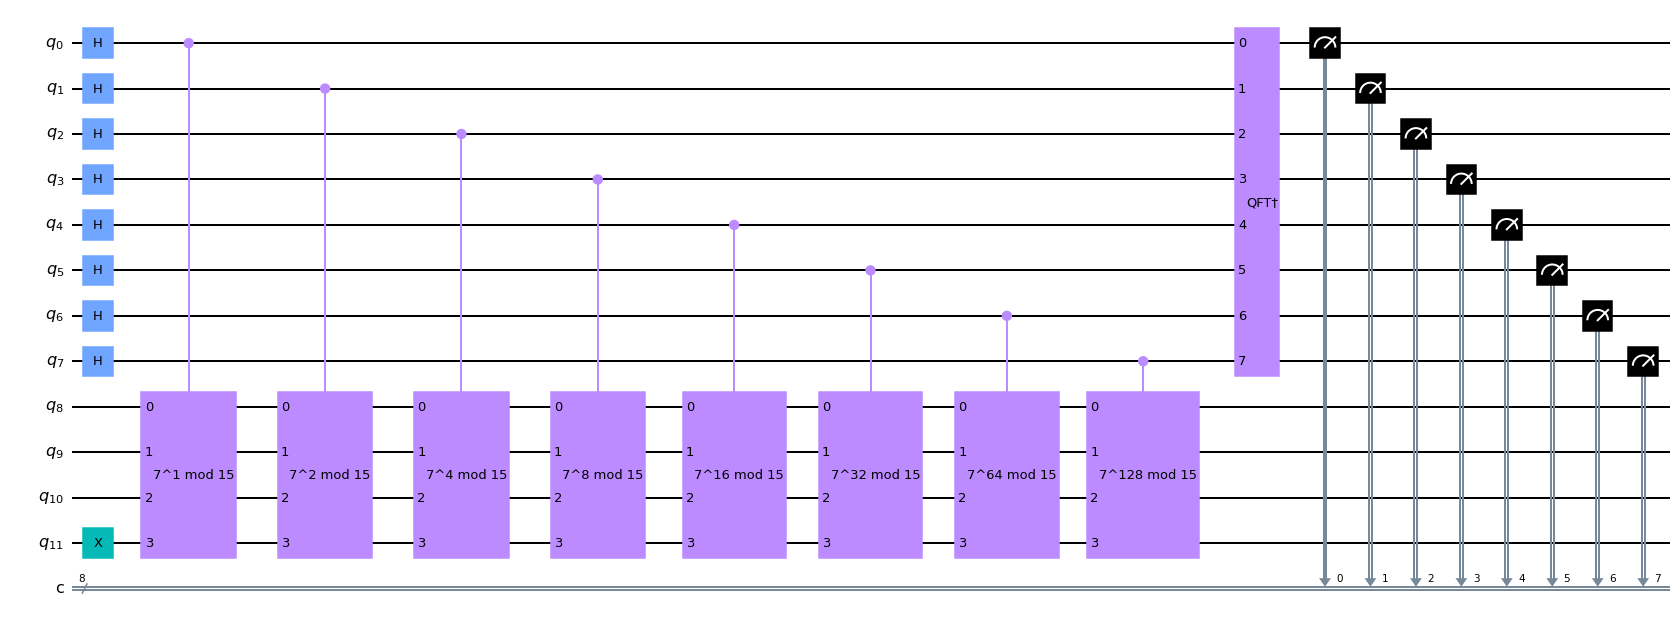

In [10]:
# Creating QuantumCircuit with n_count counting qubits
# plus 4 qubits for U to act on
qc = QC(n_count + 4, n_count)

# Initializing counting qubits
# in state |+>
for q in range(n_count):
    qc.h(q)
    
# auxiliary register in state |1>
qc.x(3+n_count)

# controlled-U operations
for q in range(n_count):
    qc.append(c_amod15(a, 2**q), 
             [q] + [i+n_count for i in range(4)])

# inverse-QFT
qc.append(qft_dagger(n_count), range(n_count))

# Measure circuit
qc.measure(range(n_count), range(n_count))
qc.draw(fold=-1)  

/opt/conda/lib/python3.8/site-packages/qiskit/utils/deprecation.py:62: DeprecationWarning: Using a qobj for run() is deprecated as of qiskit-aer 0.9.0 and will be removed no sooner than 3 months from that release date. Transpiled circuits should now be passed directly using `backend.run(circuits, **run_options).
  return func(*args, **kwargs)


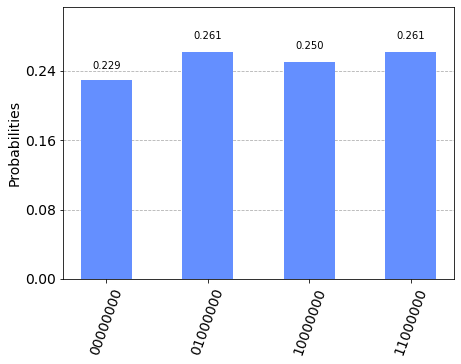

In [11]:
aer_sim = Aer.get_backend('aer_simulator')
t_qc = transpile(qc, aer_sim)
qobj = assemble(t_qc)
results = aer_sim.run(qobj).result()
counts = results.get_counts()
plot_histogram(counts)

In [13]:
rows, measured_phases = [], []
for output in counts:
    decimal = int(output, 2) 
    phase = decimal/(2**n_count)  
    measured_phases.append(phase)
    rows.append([f"{output}(bin) = {decimal:>3}(dec)", 
                 f"{decimal}/{2**n_count} = {phase:.2f}"])
# Printing rows in a table
headers=["Register Output", "Phase"]
df = pd.DataFrame(rows, columns=headers)
print(df)

            Register Output           Phase
0  11000000(bin) = 192(dec)  192/256 = 0.75
1  01000000(bin) =  64(dec)   64/256 = 0.25
2  00000000(bin) =   0(dec)    0/256 = 0.00
3  10000000(bin) = 128(dec)  128/256 = 0.50


In [14]:
# Geting fraction that most closely resembles 0.666
# with denominator < 15
Fraction(0.666).limit_denominator(15)

Fraction(2, 3)